In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from funciones_auxiliares import plot_spectra, analyze_image, analyze_tiff_metadata, PATH, crop_central_region
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, SqueezeNet1_1_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import os


def set_seed(seed=42):
    """
    Configura todas las semillas posibles para reproducibilidad.
    
    Args:
        seed (int): Valor de la semilla
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para multi-GPU
    
    # Algunas operaciones en cuDNN son no determinísticas
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    
    # Asegurar que las operaciones sean determinísticas en todas las plataformas
    #torch.use_deterministic_algorithms(True, warn_only=True)
    
    print(f"Semillas aleatorias configuradas a: {seed}")

# Llama esta función al inicio de tu script
set_seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)


Semillas aleatorias configuradas a: 42


In [2]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.Lambda(lambda x: crop_central_region(x, center_ratio=0.8)),
    transforms.ToTensor()
])

formats = ( 'RGB.JPG','RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG',)
dataset = CherryTreeDataset(PATH, transform=transform, formats = formats, concatenate = True, healthy_ratio=4)

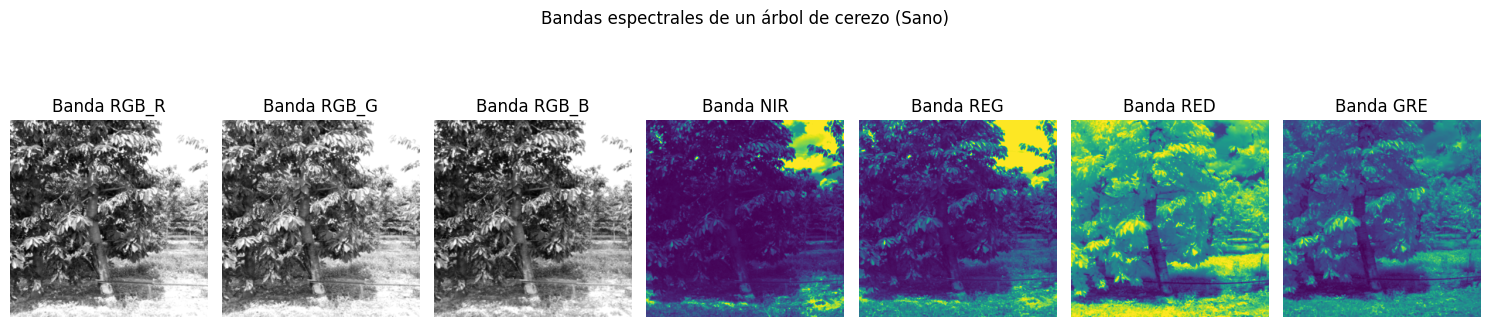

Number of samples for Healthy: 824
Number of samples for Disease: 206


In [3]:
images, label = dataset[20]  
plot_spectra(images, label)
dataset.print_class_counts()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

El dispositivo seleccionado es cuda


In [5]:
# Separa los índices por clase
healthy_indices = []
disease_indices = []

for i, (_, label) in enumerate(dataset.samples):
    if label == 0:  # Healthy
        healthy_indices.append(i)
    else:  # Disease
        disease_indices.append(i)
# Mezcla los índices
np.random.shuffle(healthy_indices)
np.random.shuffle(disease_indices)

# Divide en entrenamiento y prueba (80% - 20%)
train_healthy = healthy_indices[:int(0.8 * len(healthy_indices))]
test_healthy = healthy_indices[int(0.8 * len(healthy_indices)):]

train_disease = disease_indices[:int(0.8 * len(disease_indices))]
test_disease = disease_indices[int(0.8 * len(disease_indices)):]

# Combina los índices
train_indices = np.concatenate([train_healthy, train_disease])
test_indices = np.concatenate([test_healthy, test_disease])

# Mezcla los índices combinados
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Crea los subconjuntos
from torch.utils.data import Subset
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Crea los dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=20,  worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=20,  worker_init_fn=seed_worker)

In [6]:
train_healthy_ratio = len(train_healthy) / len(train_indices)
test_healthy_ratio = len(test_healthy) / len(test_indices)

pos_weight = torch.tensor([len(train_healthy) / len(train_disease)]).to(device)

print(f"Ratio de muestras saludables en entrenamiento: {train_healthy_ratio:.4f}")
print(f"Ratio de muestras saludables en prueba: {test_healthy_ratio:.4f}")

Ratio de muestras saludables en entrenamiento: 0.8007
Ratio de muestras saludables en prueba: 0.7971


In [7]:
#resnet = models.squeezenet1_1(SqueezeNet1_1_Weights.IMAGENET1K_V1)
#resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# Adapta el modelo para aceptar 4 canales
resnet = adapt_resnet_channels(resnet, 7)

print(resnet)


num_classes = 2  # Número de clases en tu dataset

resnet.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(resnet.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

for m in resnet.fc.modules():
    if isinstance(m, nn.Linear):
        # Inicialización He (Kaiming) para capas con ReLU
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu', generator=torch.Generator().manual_seed(42))
        # Inicializar bias en cero (opcional, este es el valor por defecto)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
resnet.to(device)

for param in resnet.parameters():
    param.requires_grad = False


# Descongelar todas las capas en `layer4`
for param in resnet.layer4.parameters():
    param.requires_grad = True
#for param in resnet.layer3.parameters():
#    param.requires_grad = True
#for param in resnet.conv1.parameters():
#    param.requires_grad = True

# Descongelar la capa `avgpool` y `fc`
for param in resnet.avgpool.parameters():
    param.requires_grad = True

for param in resnet.fc.parameters():
    param.requires_grad = True

#print(resnet)
#for name, param in resnet.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")



ResNet(
  (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

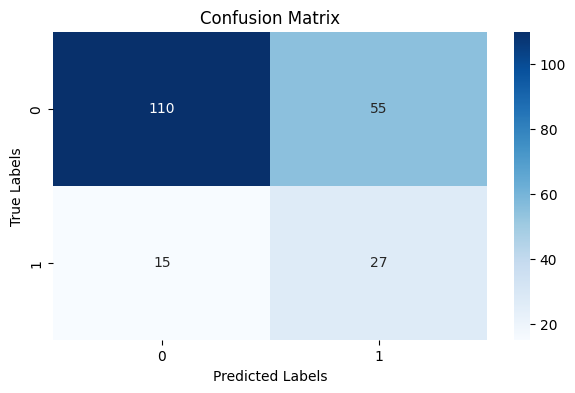

Precision: 0.3293, Recall: 0.6429, F1-Score: 0.4355
AUC-ROC: 0.5625
Epoch [1/5], Train Loss: 1.7852, Validation Loss: 1.1425, Accuracy: 66.18%


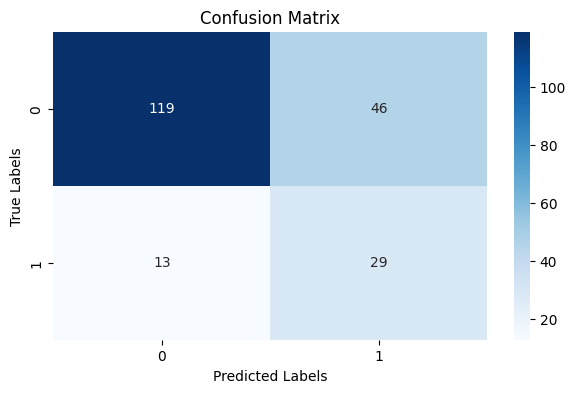

Precision: 0.3867, Recall: 0.6905, F1-Score: 0.4957
AUC-ROC: 0.5252
Epoch [2/5], Train Loss: 1.7364, Validation Loss: 0.9888, Accuracy: 71.50%


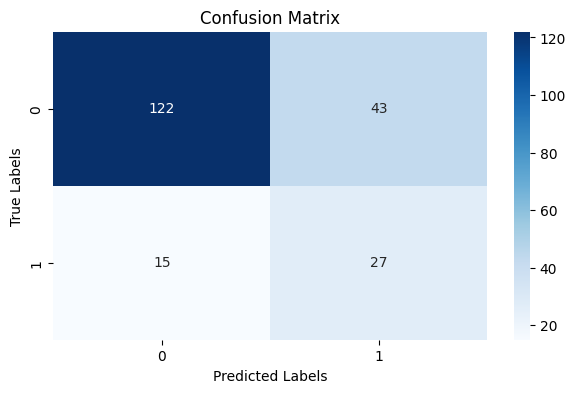

Precision: 0.3857, Recall: 0.6429, F1-Score: 0.4821
AUC-ROC: 0.4968
Epoch [3/5], Train Loss: 1.9870, Validation Loss: 1.0034, Accuracy: 71.98%


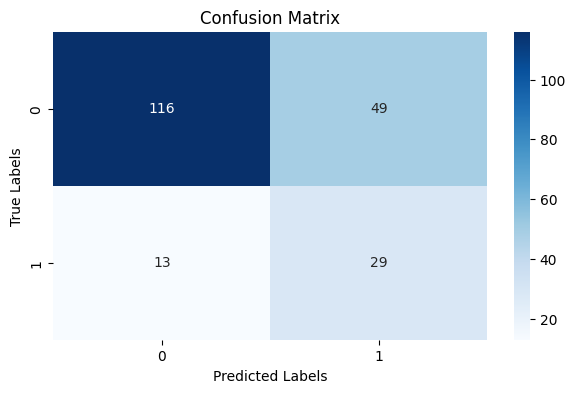

Precision: 0.3718, Recall: 0.6905, F1-Score: 0.4833
AUC-ROC: 0.5996
Epoch [4/5], Train Loss: 1.7595, Validation Loss: 1.0934, Accuracy: 70.05%


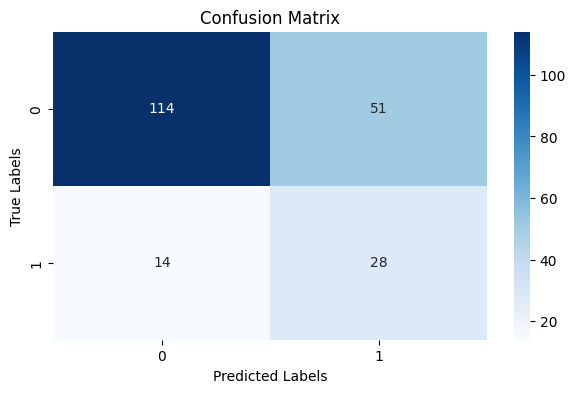

Precision: 0.3544, Recall: 0.6667, F1-Score: 0.4628
AUC-ROC: 0.4946
Epoch [5/5], Train Loss: 1.6766, Validation Loss: 1.0551, Accuracy: 68.60%


In [13]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

for param in resnet.parameters():
    param.requires_grad = True

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0000001, weight_decay=1e-4 )
num_epochs = 5
for epoch in range(num_epochs):
    resnet.train()
    train_loss = 0
    for images, labels in train_loader:
        #print('iter')
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculando la pérdida promedio en la época
    train_loss /= len(train_loader)

    resnet.eval()
    validation_loss = 0
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # Obtén las predicciones binarias
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Guarda las predicciones y etiquetas para la matriz de confusión
            # Importante: aplana los arrays para que sean 1D
            all_predicted.extend(predicted.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    validation_loss /= len(test_loader)
    accuracy = 100 * correct / total
    
    # Convierte a arrays numpy para la matriz de confusión
    all_predicted = np.array(all_predicted)
    all_labels = np.array(all_labels)
    
    # Calculando la matriz de confusión
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(7,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='binary')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    
    # Si quieres calcular el AUC-ROC (necesitas las probabilidades, no las etiquetas binarias)
    all_probs = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = resnet(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probs)
    
    auc_roc = roc_auc_score(all_labels, all_probs)
    print(f'AUC-ROC: {auc_roc:.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [ ]:
print((predicted == labels))